# Here we show how the IndexGenerator class can be used to produce activity indices corresponding to spatial patterns, how other field data can be projected onto those patterns, and how the PredictionTest class can be used to quickly assess the predicitive value of the indices.

## For our example case will attempt to predict the next-day decay of Greenland blocking events from Z500 anomaly fields

In [56]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from domino.core import LaggedAnalyser,IndexGenerator
from domino.prediction import PredictionTest

In [3]:
#Load in and process necessary data
Z500_data=xr.open_dataarray('data/Z500.nc').load()
regime_lifecycles=xr.open_dataarray('data/Grams_regime_lifecycles.nc')
Z500_data,regime_lifecycles=xr.align(Z500_data,regime_lifecycles)

#Define the decay event time series: 0 if a GL event does not decay in the next day, 1 if it does.
is_GL= regime_lifecycles==6
isnt_GL= regime_lifecycles!=6
GL_decay_arr=is_GL[:-1].values*isnt_GL[1:].values
GL_decay=xr.DataArray(data=GL_decay_arr,coords={'time':regime_lifecycles.time[:-1]})

Z500_data,GL_decay=xr.align(Z500_data,GL_decay)

## Here we split our data into a period 1979-2000 in which we will identify the precursor pattern associated with Greenland blocking decay, and 2000-2021 data which we will use to test the skill of the methodology:

In [10]:
training_predictor=Z500_data.isel(time=Z500_data['time.year']<=2000)
training_event=GL_decay.isel(time=GL_decay['time.year']<=2000)

test_predictor=Z500_data.isel(time=Z500_data['time.year']>2000)
test_event=GL_decay.isel(time=GL_decay['time.year']>2000)

In [11]:
composite_pattern=LaggedAnalyser(event=training_event,variables=training_predictor,
                    name='my_predictor').compute_composites()
composite_pattern=composite_pattern.sel(index_val=1,lag=0)

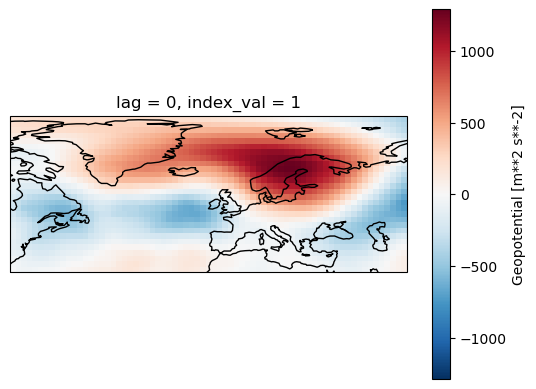

In [14]:
p=composite_pattern.my_predictor.plot(transform=ccrs.PlateCarree(),
                    subplot_kws=dict(projection=ccrs.PlateCarree()))
p.axes.coastlines()

# We see the average GL decay involves an anticyclonic anomaly moving downstream over Scandinavia.

## now we wish to define an index from this pattern. The IndexGenerator class has a 'generate' method, which takes in a dataset of patterns and a dataset of spatial fields.
## It then projects the field data onto the patterns, returning standardised scalar indices:

In [50]:
IG=IndexGenerator()
training_index=IG.generate(composite_pattern,training_predictor)

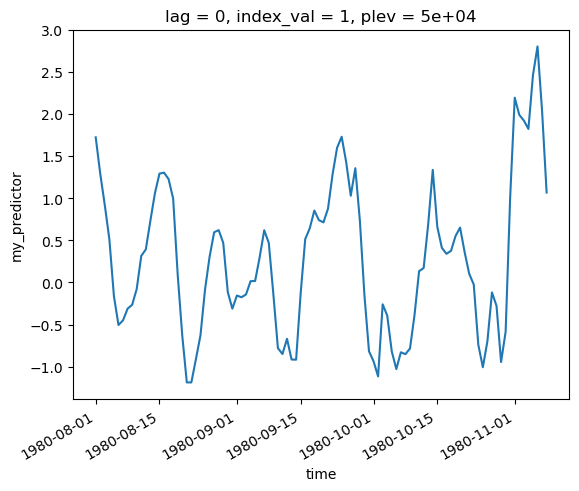

In [27]:
training_index.my_predictor[:100].plot();

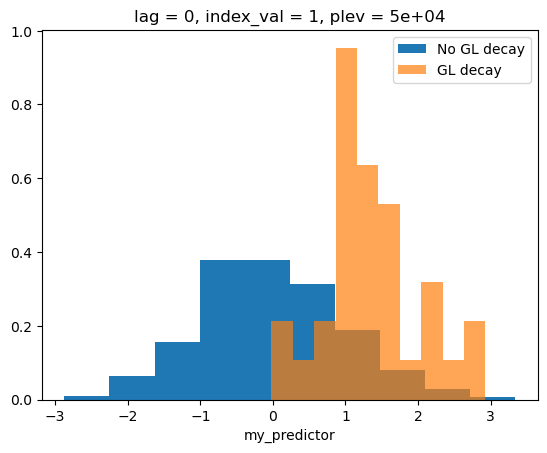

In [41]:
training_index.my_predictor.where(training_event==0).plot.hist(density=1,label='No GL decay')
p=training_index.my_predictor.where(training_event==1).plot.hist(density=1,alpha=0.7,label='GL decay')
plt.legend()

## We can now do the same for our test data, with one difference: we want to use the standardisation parameters (i.e. the mean index value to subtract and standard deviation to divide by) from our training data, instead of recomputing it from the test data which would make them incomparable. This is easy, as IndexGenerator stores these params:

In [51]:
standardisation_params=IG.get_standardisation_params()
ixmean=standardisation_params.sel(param='mean')
ixstd=standardisation_params.sel(param='std')

test_index=IG.generate(composite_pattern,test_predictor,ix_means=ixmean,ix_stds=ixstd)

## How much difference does this make? We can see it does impact the standard deviation of the index, although not by too much. If our two datasets were from different models or were further apart in time, the difference could be more significant.

#### [n.b. in some cases it might be desirable to standardise indices computed in different data separately as this will provide some calibration for mean state differences]

In [52]:
test_index_v2=IG.generate(composite_pattern,test_predictor)

Text(0, 0.5, 'Standardised with test index directly')

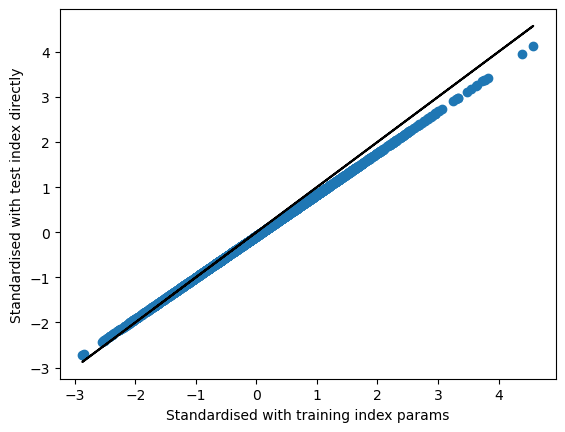

In [54]:
plt.scatter(test_index.my_predictor,test_index_v2.my_predictor)
plt.plot(test_index.my_predictor,test_index.my_predictor,color='k')
plt.gca().set_xlabel('Standardised with training index params')
plt.gca().set_ylabel('Standardised with test index directly')

# Now we have computed our indices, we can use PredictionTest to assess their predictive power.

## We will just fit a simple logistic regression, predicting the probability of a GL decay from the index value, computing skill with the ROC Area Under the Curve (ROC-AUC)

## PredictionTest takes a predictor dataset and a target dataseries as inputs.
## We then compute skill using the 'categorical_prediction' method. For cross validation, as we have already split our data into train and test, we use the cv_method='manual', and pass our test data in via the cv_kwargs argument:

In [57]:
PT=PredictionTest(training_index,training_event)  
CV_ROC_AUC=PT.categorical_prediction('logregression',score='sklearn_roc_auc',cv_method='manual',
    cv_kwargs=dict(test_pred=test_index,test_targ=test_event))

In [61]:
print(CV_ROC_AUC.my_predictor.values)

[0.81490485]


## A ROC_AUC score of 0.81 seems pretty good! Now we can finally predict blocking decay!
## Ah but we have forgotten that a fairer test would be to predict Greenland blocking decay given that a Greenland blocking event is currently occurring...

## No problem, it is easy to repeat our analysis with this correction in place:

In [69]:
test_index=test_index.where(is_GL==1).dropna('time')
training_index=training_index.where(is_GL==1).dropna('time')

test_event=test_event.where(is_GL==1).dropna('time')
training_event=training_event.where(is_GL==1).dropna('time')

In [70]:
PT=PredictionTest(training_index,training_event)  
CV_ROC_AUC=PT.categorical_prediction('logregression',score='sklearn_roc_auc',cv_method='manual',
    cv_kwargs=dict(test_pred=test_index,test_targ=test_event))

In [72]:
print(CV_ROC_AUC.my_predictor.values)

[0.58688388]


## Oh dear, A ROC_AUC of 0.58 is not so impressive... We may have to try something else...

## But luckily, now we know how to use Domino to compute activity indices and assess their skill, it won't take us long to try other ideas!